In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from Autoencoders import ConformalAutoencoder

import optuna.visualization as vis
import optuna

from torchvision.datasets import MNIST
from torchvision import transforms

random_state = 42
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:1


In [2]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super(Encoder, self).__init__()
        #input dim = 1, 32, 32
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3, stride=1, padding=1),  # (8, 32, 32)
            nn.ELU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # (16, 16, 16)
            nn.ELU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (32, 8, 8)
            nn.ELU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (64, 4, 4)
            nn.ELU(True),
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),  # Flatten to (256,)
            nn.ELU(True),
            nn.Linear(256, 128),  # Flatten to (128,)
            nn.ELU(True),
            nn.Linear(128, latent_dim)  # Output latent dimension
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Input latent dimension
            nn.ELU(True),
            nn.Linear(128, 256),  # Input latent dimension
            nn.ELU(True),
            nn.Linear(256, 64 * 4 * 4),  # Output size to reshape
            nn.ELU(True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # (32, 8, 8)
            nn.ELU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (16, 16, 16)
            nn.ELU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),  # (8, 32, 32)
            nn.ELU(True),
            nn.ConvTranspose2d(8, out_channels, 3, stride=1, padding=1),  # (out_channels, 32, 32)
            nn.Sigmoid()  # For pixel values between 0 and 1
        )
    
    def forward(self, z):
        z = self.fc(z)
        z = torch.unflatten(z, 1, (64, 4, 4))  # Reshape to (64, 4, 4)
        z = self.deconv(z)
        return z

In [3]:
mnist = MNIST(root='data', train=True, download=True, transform=None)
data, labels = mnist.data, mnist.targets
data = data[labels == 3][:3000]
labels = labels[labels == 3]
data = torch.tensor(data, dtype=torch.float32).to(device)
data = transforms.Resize((32, 32))(data)  # Resize to 32x32
data = data / 255.0  # Normalize the images to [0, 1]
data = data.view(data.size(0), 1, 32, 32)  # Add channel dimension
mnist_val = MNIST(root='data', train=False, download=True, transform=None)
val_data, val_labels = mnist_val.data, mnist_val.targets
val_data = val_data[val_labels == 3][:1000]
val_labels = val_labels[val_labels == 3]
val_data = torch.tensor(val_data, dtype=torch.float32).to(device)
val_data = transforms.Resize((32, 32))(val_data)  # Resize to 32x32
val_data = val_data / 255.0  # Normalize the images to [0, 1]
val_data = val_data.view(val_data.size(0), 1, 32, 32)  # Add channel dimension

/tmp/ipykernel_507487/315428273.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).to(device)
/tmp/ipykernel_507487/315428273.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = torch.tensor(val_data, dtype=torch.float32).to(device)


In [11]:
from metrics import evaluate_conformality, conformality_cosine_loss, conformality_cosine_orthounit_loss, conformality_trace_loss, conformality_trace2_loss, regularization

def objective(trial):
    lambda_conf = 0.0#trial.suggest_float("lambda_conf", 0.01, 100.0, log=True)
    lambda_reg = 0.0#trial.suggest_float("lambda_reg", 0.001, 10.0, log=True)
    conf_loss = None#trial.suggest_categorical("conformality_loss", ["trace","trace2"]) #["trace","trace2", "cosine", "cosine2"]
    lambda_aug = None#0.1
    lambda_conf_schedule = None
    lambda_reg_schedule = None
    num_samples_conf = 1
    num_samples_reg = 1

    epochs = 1000
    batch_size = 256
    latent_dim = trial.suggest_int("latent_dim", 4, 128, step=4)
    learning_rate = 0.001
    scheduler_kwargs={"step_size": 100, "gamma": 0.8}

    train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
    decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
    conformal_autoencoder = ConformalAutoencoder(encoder, decoder,
                                                 lambda_conf=lambda_conf, lambda_reg=lambda_reg, lambda_aug=lambda_aug,
                                                 lambda_conf_schedule=lambda_conf_schedule, lambda_reg_schedule=lambda_reg_schedule
                                                ).to(device)
    
    if conf_loss == "trace":
        conformal_autoencoder.conformality_loss = lambda func, z: conformality_trace_loss(func, z, num_samples=num_samples_conf)
    elif conf_loss == "trace2":
        conformal_autoencoder.conformality_loss = lambda func, z: conformality_trace2_loss(func, z, num_samples=num_samples_conf)
    elif conf_loss == "cosine":
        conformal_autoencoder.conformality_loss = conformality_cosine_loss
    elif conf_loss == "cosine2":
        conformal_autoencoder.conformality_loss = conformality_cosine_orthounit_loss
    else:
        conformal_autoencoder.conformality_loss = lambda func, z: 0.0

    conformal_autoencoder.regularization_loss = lambda func, z: 0.0 #lambda func, z: regularization(func, z, num_samples=num_samples_reg)


    optimizer, scheduler = conformal_autoencoder.train_model(train_dataloader, val_dataloader, batch_size=batch_size,
                                                             epochs=epochs, learning_rate=learning_rate, log_every=epochs+1, val_every=epochs+1,
                                                             scheduler_kwargs=scheduler_kwargs)

    stats, _ = evaluate_conformality(conformal_autoencoder, val_data[:1000])

    return stats['reconstruction_error'], np.abs(np.nan_to_num(stats['log_determinant_vs_estimate_mean'], nan=10000.0))

In [12]:
n_trials = 100
study_name = "ae_dim"
storage = "sqlite:///optuna_study.db"

# sampler = optuna.samplers.NSGAIISampler()
search_space = {
    "latent_dim": np.arange(4, 129, 4).tolist(),
}
sampler = optuna.samplers.GridSampler(search_space)

study = optuna.create_study(directions=['minimize', 'minimize'], sampler=sampler, storage=storage, study_name=study_name, load_if_exists=True)
study.optimize(objective, n_trials=n_trials)

[I 2025-08-05 17:10:34,990] A new study created in RDB with name: ae_dim
[I 2025-08-05 17:11:25,375] Trial 0 finished with values: [0.007100341375917196, 85.36600494384766] and parameters: {'latent_dim': 48}.
[I 2025-08-05 17:12:16,082] Trial 1 finished with values: [0.008529391139745712, 10000.0] and parameters: {'latent_dim': 92}.
[I 2025-08-05 17:13:07,458] Trial 2 finished with values: [0.007157608401030302, 71.15723419189453] and parameters: {'latent_dim': 44}.
[I 2025-08-05 17:13:58,849] Trial 3 finished with values: [0.010633924975991249, 2.7115142345428467] and parameters: {'latent_dim': 12}.
[I 2025-08-05 17:14:50,302] Trial 4 finished with values: [0.008031499572098255, 10000.0] and parameters: {'latent_dim': 68}.
[I 2025-08-05 17:15:41,746] Trial 5 finished with values: [0.006558241322636604, 10000.0] and parameters: {'latent_dim': 60}.
[I 2025-08-05 17:16:33,848] Trial 6 finished with values: [0.006940251216292381, 10000.0] and parameters: {'latent_dim': 116}.
[I 2025-08-05

In [ ]:
# optuna.delete_study(study_name="ae_dim", storage=storage)

In [ ]:
# study = optuna.load_study(
#     study_name='my_study',
#     storage='sqlite:///optuna_study.db'
# )

In [13]:
vis.plot_param_importances(study)

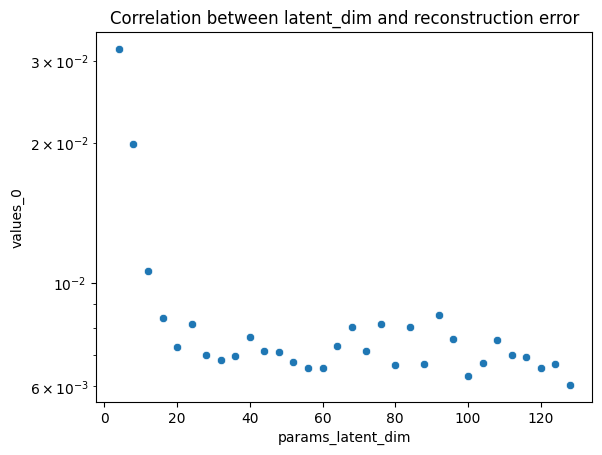

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert trials to DataFrame
df = study.trials_dataframe()

# Optional: filter only completed trials
df = df[df['state'] == 'COMPLETE']

# Choose a parameter
param1 = 'latent_dim'

# Plot param vs loss
sns.scatterplot(data=df, x=f'params_{param1}', y='values_0')  # Assuming first value is reconstruction error
plt.title(f"Correlation between {param1} and reconstruction error")
# plt.ylim(0, 0.03)
plt.yscale('log')
plt.show()

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert trials to DataFrame
df = study.trials_dataframe()

# Optional: filter only completed trials
df = df[df['state'] == 'COMPLETE']

# Choose a parameter
param1 = 'lambda_conf'  # or 'lambda_reg'
param2 = 'lambda_reg'

# Plot param vs loss
sns.scatterplot(data=df, x=f'params_{param1}', y='values_0')  # Assuming first value is reconstruction error
plt.title(f"Correlation between {param1} and reconstruction error")
# plt.ylim(0, 0.03)
plt.xscale('log')
plt.show()
sns.scatterplot(data=df, x=f'params_{param1}', y='values_1')  # Assuming 'value' is the loss
plt.xlabel(f'Parameter: {param1}')
plt.ylabel('Loss')
plt.xscale('log')  # Use logarithmic scale for better visibility
# plt.ylim(-1, 0)  # Adjust y-axis limit if necessary
plt.title(f"Correlation between {param1} and loss")
plt.show()
sns.scatterplot(data=df, x=f'params_{param2}', y='values_0')  # Assuming 'value' is the loss
plt.title(f"Correlation between {param2} and reconstruction error")
plt.xscale('log')
plt.show()
sns.scatterplot(data=df, x=f'params_{param2}', y='values_1')  # Assuming 'value' is the loss
plt.xlabel(f'Parameter: {param2}')
plt.ylabel('Loss')
# plt.ylim(-1, 0)  # Adjust y-axis limit if necessary
plt.title(f"Correlation between {param2} and loss")
plt.xscale('log')
plt.show()

ValueError: Could not interpret value `params_lambda_conf` for `x`. An entry with this name does not appear in `data`.

In [14]:
vis.plot_pareto_front(study)

In [15]:
import optuna.visualization as vis
vis.plot_contour(study, params=[param1, param2], target=lambda t: t.values[0])  # Assuming first value is reconstruction error

NameError: name 'param1' is not defined

In [13]:
print(study.trials_dataframe())

   number  values_0   values_1             datetime_start  \
0       0  0.131074  -0.195635 2025-07-28 17:43:49.210484   
1       1  0.077975  -0.437632 2025-07-28 17:43:55.598358   
2       2  0.118359  -0.008398 2025-07-28 17:44:01.260308   
3       3  0.067868  -0.062619 2025-07-28 17:44:06.906381   
4       4  0.132944  -0.123222 2025-07-28 17:44:12.574133   
5       5  0.032433  -0.916306 2025-07-28 17:44:18.240920   
6       6  0.149123  -0.382525 2025-07-28 17:44:23.903965   
7       7  0.121743  -0.962378 2025-07-28 17:44:29.568981   
8       8  0.054965 -10.185285 2025-07-28 17:44:35.251230   
9       9  0.103213  -0.011462 2025-07-28 17:44:40.906889   

           datetime_complete               duration  params_lambda_conf  \
0 2025-07-28 17:43:55.597779 0 days 00:00:06.387295            3.450764   
1 2025-07-28 17:44:01.259687 0 days 00:00:05.661329            4.271127   
2 2025-07-28 17:44:06.905917 0 days 00:00:05.645609            6.949206   
3 2025-07-28 17:44:12.573647